# Libraries

In [13]:
#        DATA
# ==================== #
import pandas as pd
import numpy as np
from scipy import stats
import time
import random
import math
pd.set_option('display.max_columns', None)
#      PLOTING
# ============================== #

from PIL import Image
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="white")

#      TimeSeries
# ============================================================================== #

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

#      OTHERS
# ============================== #
from sklearn.inspection import permutation_importance
import multiprocessing

from python.funcionesPropias import *

#      WARNINGS
# ============================== #
import warnings
warnings.filterwarnings("ignore")
import dill

# Data

In [2]:
df = pd.read_csv('./data/dfFinal.csv')
print(f"Tenemos {df.shape[1]} columnas y {df.shape[0]} filas")

Tenemos 25 columnas y 116 filas


In [3]:
df.drop(['mes_x', 'ano_x','mes_y', 'ano_y'], axis=1, inplace=True)

In [4]:
df.columns = ['fecha','volumenMetro', 'tmed', 'prec', 'tmin', 'tmax', 'dir',
       'velmedia', 'racha', 'presMax', 'presMin', 'tmedStd', 'precStd',
       'tminStd', 'tmaxStd', 'dirStd', 'velmediaStd', 'rachaStd', 'presMaxStd',
       'presMinStd', 'festividad']

In [5]:
df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')
df = df.set_index('fecha')
df = df.asfreq('MS')
df = df.sort_index()
df.head()

,volumenMetro,tmed,prec,tmin,tmax,dir,velmedia,racha,presMax,presMin,tmedStd,precStd,tminStd,tmaxStd,dirStd,velmediaStd,rachaStd,presMaxStd,presMinStd,festividad
fecha,,,,,,,,,,,,,,,,,,,,
2012-01-01,54.763,6.406977,0.203846,1.382558,11.434884,15.588235,1.338710,7.022353,950.138710,946.116129,1.655209,1.096090,2.187031,2.519420,16.545963,0.998807,3.245487,4.832518,5.471961,NaN
2012-02-01,55.723,5.916092,0.185882,-0.298851,12.122989,11.232558,2.111494,10.916279,947.596552,943.972414,3.762510,0.962654,3.378747,4.965361,13.231579,1.043855,4.453838,2.894700,3.613124,NaN
2012-03-01,57.169,11.526437,0.782759,5.331034,17.702299,15.643678,1.897701,8.625287,948.122581,944.306452,3.116888,3.253807,2.799681,4.301162,13.378199,0.834848,2.448930,3.323608,3.451389,NaN
2012-04-01,50.379,11.384706,1.792857,6.632941,16.152941,23.746988,2.818824,11.849398,935.436667,931.023333,2.304008,3.193359,2.257337,3.344312,8.821873,1.149792,2.605500,3.872676,3.467983,NaN
2012-05-01,55.199,19.009890,0.841758,12.427473,25.591209,19.692308,2.112088,9.547253,941.112903,937.464516,5.104879,2.609813,4.285922,6.244102,9.254059,0.849946,2.228469,4.266664,4.324581,NaN


In [6]:
df = df.query("fecha < '01-01-2020'")

In [7]:
# Verificar que un índice temporal está completo
# ==============================================================================
(df.index == pd.date_range(
                    start = df.index.min(),
                    end   = df.index.max(),
                    freq  = df.index.freq)
).all()

#https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html

True

# FE

In [9]:
df['diffTemp'] = df['tmax']-df['tmin']

In [11]:
df['diffPres'] = df['presMax'] - df['presMin']

In [17]:
df['festividad'] = df.festividad.fillna(0)

In [19]:
df.head()

,volumenMetro,tmed,prec,tmin,tmax,dir,velmedia,racha,presMax,presMin,tmedStd,precStd,tminStd,tmaxStd,dirStd,velmediaStd,rachaStd,presMaxStd,presMinStd,festividad,diffTemp,diffPres
fecha,,,,,,,,,,,,,,,,,,,,,,
2012-01-01,54.763,6.406977,0.203846,1.382558,11.434884,15.588235,1.338710,7.022353,950.138710,946.116129,1.655209,1.096090,2.187031,2.519420,16.545963,0.998807,3.245487,4.832518,5.471961,0.0,10.052326,4.022581
2012-02-01,55.723,5.916092,0.185882,-0.298851,12.122989,11.232558,2.111494,10.916279,947.596552,943.972414,3.762510,0.962654,3.378747,4.965361,13.231579,1.043855,4.453838,2.894700,3.613124,0.0,12.421839,3.624138
2012-03-01,57.169,11.526437,0.782759,5.331034,17.702299,15.643678,1.897701,8.625287,948.122581,944.306452,3.116888,3.253807,2.799681,4.301162,13.378199,0.834848,2.448930,3.323608,3.451389,0.0,12.371264,3.816129
2012-04-01,50.379,11.384706,1.792857,6.632941,16.152941,23.746988,2.818824,11.849398,935.436667,931.023333,2.304008,3.193359,2.257337,3.344312,8.821873,1.149792,2.605500,3.872676,3.467983,0.0,9.520000,4.413333
2012-05-01,55.199,19.009890,0.841758,12.427473,25.591209,19.692308,2.112088,9.547253,941.112903,937.464516,5.104879,2.609813,4.285922,6.244102,9.254059,0.849946,2.228469,4.266664,4.324581,0.0,13.163736,3.648387


# Models

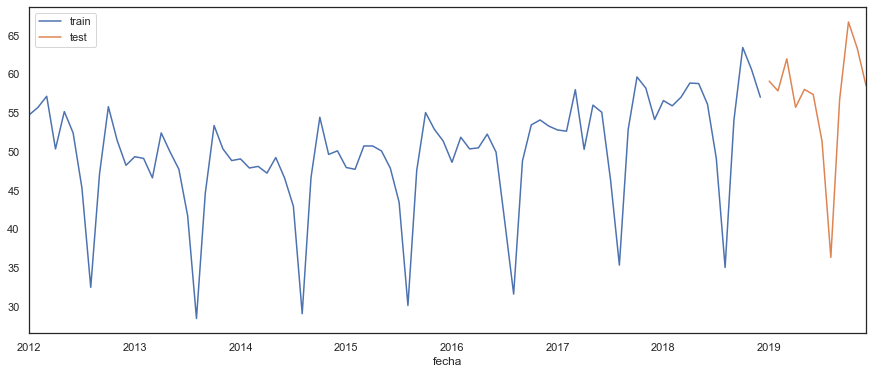

In [28]:
# Train-test split
# ==============================================================================
steps = 12
train = df[:-steps]
test  = df[-steps:]

fig, ax = plt.subplots(figsize=(15, 6))
train['volumenMetro'].plot(ax=ax, label='train')
test['volumenMetro'].plot(ax=ax, label='test')
ax.legend();